# 4. FIB-SEM reconstruction

In this notebook we'll use elastix to
- reconstruct a FIB-SEM dataset
- perform drift correction of a timelapse

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import itk
from tqdm import tqdm

## FIB-SEM reconstruction

FIB-SEM is a volumetric imaging technique in which
- the surface of a block is imaged using Scanning Electron Microscopy (SEM)
- the top layer of the block is ablated using a Focused Ion Beam (FIB)
- this is repeated n times to obtain a volume of n slices

Typically the slices exhibit deformations with respect to each other and a high quality 3D stack can be reconstructed by registering slices sequentially.

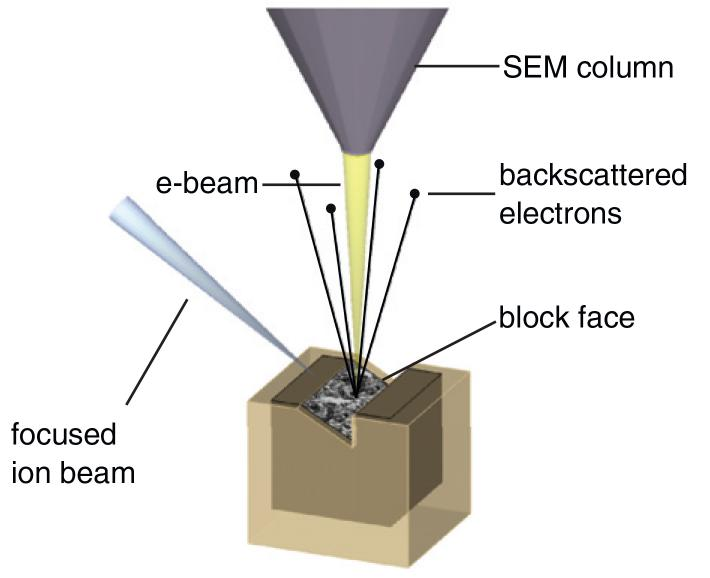!

(from Briggman and Bock, Curr. Op. in Neurobiol. 2012)

### Load and visualize the data

The image used is a subset of the dataset available here:
https://www.ebi.ac.uk/bioimage-archive/galleries/EMPIAR-10479/IM1.html

In [36]:
im = io.imread('../example_data/fibsem.tif')

In [6]:
# visualise

import napari
viewer = napari.Viewer()

viewer.add_image(im)

<Image layer 'im' at 0x282ede2c0>

In [51]:
n_slices = im.shape[0]
print('Image shape is %s in z, y, x' %list(im.shape))

Image shape is [41, 168, 251] in z, y, x


### Defining the registration parameters

For FIB-SEM acquisitions, registration typically requires nonlinear registration. Here, we perform first a linear and then a nonlinear transformation.

In [52]:
registration_parameter_object = itk.ParameterObject.New()

registration_parameter_object.AddParameterMap(itk.ParameterObject.New().GetDefaultParameterMap('translation'))
pmap_bspline = itk.ParameterObject.New().GetDefaultParameterMap('bspline')
pmap_bspline['GridSpacingSchedule'] = [str(v) for v in [10] * 4]

registration_parameter_object.AddParameterMap(pmap_bspline)

### Reconstruction

Our strategy will be to
- choose the first slice as a reference slice
- register neighboring slices to each other
- transform each slice by chaining together all pairwise transformations between the slice and the reference slice

In [47]:
# initialise the corrected stack as a list, containing the unmodified reference slice
corrected_slices = [im[0]]

# initialise a parameter object to which the transforms will be appended that result from the pairwise slice registrations
curr_transform_object = itk.ParameterObject.New()

# the first fixed image will be the reference slice
fixed_image_itk = itk.GetImageFromArray(im[0])
for z in tqdm(range(1, n_slices)):
# for z in tqdm(range(1, 6)):

    # the moving image is the current slice
    moving_image_itk = itk.GetImageFromArray(im[z])

    # perform the pairwise registration between two slices 
    transformed_moving_image, result_transform_parameters = itk.elastix_registration_method(
        fixed_image_itk,
        moving_image_itk,
        parameter_object=registration_parameter_object,
        log_to_console=False
        )

    # set the current moving image as the fixed image for the registration in the next iteration
    fixed_image_itk = moving_image_itk

    # append the obtained transform to the transform parameter object
    curr_transform_object.AddParameterMap(result_transform_parameters.GetParameterMap(0))

    # transform the current slice and append it to the reconstructed stack
    curr_slice = itk.transformix_filter(moving_image_itk, curr_transform_object)
    corrected_slices.append(np.array(curr_slice))

# convert the list of 2D slices into a 3D numpy array 
corrected_slices = np.array(corrected_slices)

100%|██████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


In [49]:
import napari
viewer = napari.Viewer()

viewer.add_image(im, name='Before correction')
viewer.add_image(corrected_slices, name='After correction')

<Image layer 'After correction' at 0x17f2ab400>

## Exercise: Drift correction

Can you use a similar approach to perform drift correction of a timelapse?

There's an example dataset available for this at '../example_data/2d_movie.tif'.